In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
from pyscf.dft import numint
import api as pyq 
import matplotlib.pyplot as plt
import importlib
import os
import h5py
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [2]:
from math import pi
# mol = gto.M(atom="H 0. 0. 0.", spin=1, basis=f'ccecpccpvdz', unit='bohr')
# mf = scf.UHF(mol)
# scf_checkfile = "scf.hdf5"
# dm = mf.init_guess_by_atom()
# mf.kernel(dm)
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 1.2", basis=f'ccecpccpvdz', unit='bohr')
mf = scf.RKS(mol)
scf_checkfile = "scf.hdf5"
# dm = mf.init_guess_by_atom()

factor = -3.0/4.0 * (3.0 / pi)**(1.0/3.0)
power = 4.0/3.0
def eval_xc(rho, a=factor, p=power):
    exc = a * rho ** p
    vrho = a * p * rho ** (p-1.0)
    vxc = (vrho, None, None, None)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc


def my_eval_xc(a,p):    
    def eval_xc(xc_code, rho, *args, **kwargs):
        exc = a * rho ** p
        vrho = a * p * rho ** (p-1.0)
        vxc = (vrho, None, None, None)
        fxc = None  # 2nd order functional derivative
        kxc = None  # 3rd order functional derivative
        return exc, vxc, fxc, kxc
    return eval_xc
mf = mf.define_xc_(my_eval_xc(factor,power), 'LDA')
mf.kernel()

converged SCF energy = -0.514495249426118


-0.5144952494261182

In [44]:
dm = mf.make_rdm1()
kin = mf.mol.intor_symmetric('int1e_kin')
ein = mf.mol.intor_symmetric('int1e_nuc')
j, k= mf.get_jk(mf.mol, dm)

In [4]:
#Ekin
ekin = np.einsum('ij,ji->', kin, dm).real
#EI
ei = np.einsum('ij,ji->', ein, dm).real
#EJ
ej = 0.5*np.einsum('ij,ji->', j, dm).real
ek = 0.5*np.einsum('ij,ji->', k, dm).real
#ENUC
enuc = mf.energy_nuc()
print('e1', ekin + ei, 'coul', ej, 'nuc', enuc)
#Compare to PYSCF
print(mf.scf_summary)

e1 -2.6362100218705327 coul 1.3698658136047206 nuc 0.8333333333333334
{'e1': -2.6362100218705327, 'coul': 1.3698658136047206, 'exc': -0.6843546298660804, 'nuc': 0.8333333333333334}


In [5]:
mf.mo_energy

array([-0.39538984,  0.09192526,  0.3864765 ,  0.82554954,  1.02186389,
        1.02186389,  1.77997388,  1.81619115,  1.81619115,  3.887468  ])

In [6]:
mf.energy_tot()

-1.117365504798559

In [63]:
size = 1000
pos = np.linspace([0.,0.,0.],[0.,0., 1.2], size)
# np.zeros((size, 3))
# for i in range(3):
#     pos[:,i] = np.random.normal(0, 2, size)
r = np.linalg.norm(pos, axis=1)
# pos.shape

In [64]:
aox = dft.numint.eval_ao(mol, pos, deriv=2)
ao0 = aox[0]
ao1 = aox[1:4]
ao2 = aox[4:4]
orb_coeffs = mf.mo_coeff[0]

In [97]:
ts = -0.5 * np.einsum('xgp,p,xgq,q->g', ao1, orb_coeffs, ao1, orb_coeffs)

In [103]:
mo_value = np.einsum('ij,jk,k->ik', ao0, mf.mo_coeff, mf.mo_occ)
rho = np.einsum('ij,ji->i', mo_value, mo_value.T) 
excd, vxcs  = eval_xc(rho_p)[:2]
vxc = vxcs[0]
rho_orig = numint.eval_rho(mol, ao0, dm, xctype='LDA')
excd_l, vxcs_l  = dft.libxc.eval_xc('LDA', rho)[:2]
vxcl = vxcs_l[0]

vh = []
eh = []
for i, ri in enumerate(pos):
    with mol.with_rinv_origin(ri):
        # pdb.set_trace()
        vh.append(np.einsum('ij,ij', mol.intor('int1e_rinv'), dm).real)
        eh.append(np.einsum('ij,ij', mol.intor('int1e_rinv'), dm).real*rho_p[i])
vh = np.array(vh)        
vh_2 = np.einsum('ij,jk,ki->i', ao0, j, ao0.T).real

eh = np.array(eh)            
# vi = []            
# for ri in pos:
#     vii = np.linalg.norm(ri)
#     vi.append(-1./(vii))
# vi = np.array(vi)



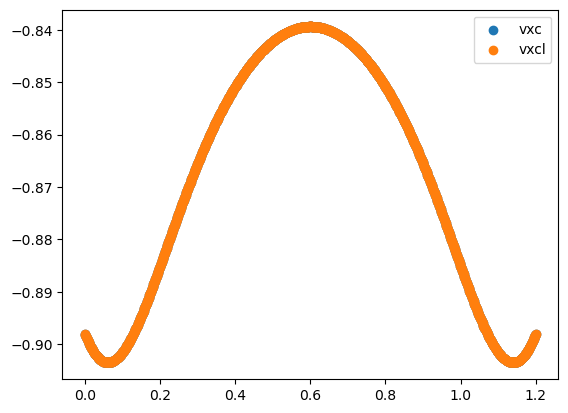

In [112]:
plt.scatter(r, vxc, label='vxc')
plt.scatter(r, vxcl, label='vxcl')
plt.legend()

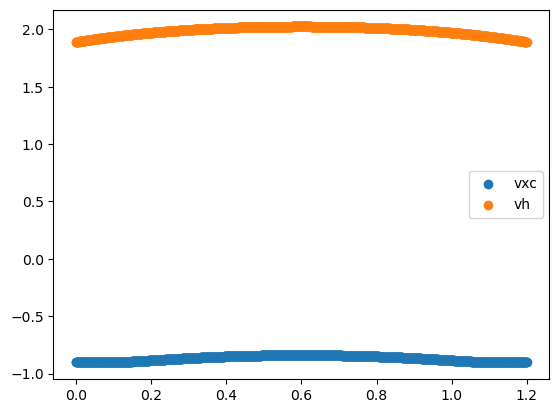

In [115]:
# plt.scatter(r, rho_p, label='rho')
plt.scatter(r, vxc, label='vxc')
# plt.scatter(r, vxcl, label='vxcl')
# plt.scatter(r, excd, label='exc')
# plt.scatter(r, excd_l*rho, label='excl')
plt.scatter(r, vh, label='vh')
# plt.scatter(r, vh_2, label='vh2')
# plt.scatter(r, vh+vxc, label='vh+vxc')
# plt.xlim((0,5))
# plt.ylim((-2,2))
plt.legend()

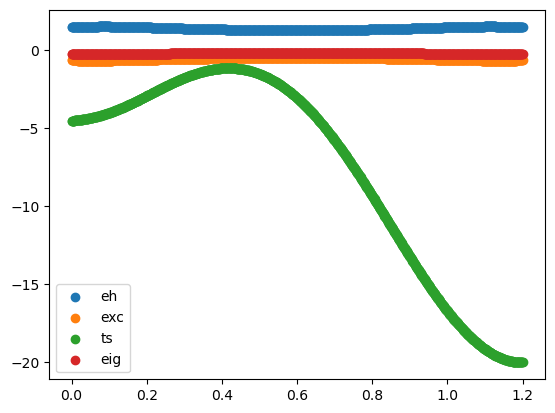

In [100]:
plt.scatter(r, eh, label='eh')
plt.scatter(r, vxc*rho, label='exc')
plt.scatter(r, ts, label='ts')
plt.scatter(r, rho*mf.mo_energy[0], label='eig')
# plt.scatter(r, ts + eh + vxc*rho - rho*mf.mo_energy[0], label='all')
# plt.xlim((0,5))
# plt.ylim((-2,2))
plt.legend()

In [16]:
plt.scatter(r, vxc, label='vxc')
plt.scatter(r, excd/rho, label='exc/rho')
plt.legend()

NameError: name 'vxc' is not defined

In [17]:
mol = mf.mol
coords = mf.grids.coords
weights = mf.grids.weights
ao_value = numint.eval_ao(mol, coords)

In [18]:
# mo_value = np.einsum('ij,jk,k->ik', ao_value, mf.mo_coeff[0], mf.mo_occ[0])
# np.einsum('ik, ki, i', mo_value, mo_value.T, weights)


In [19]:
mf.mo_occ

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
mo_value = np.einsum('ij,jk,k->ik', ao0, mf.mo_coeff, mf.mo_occ)
rho_p = np.einsum('ij,ji->i', np.conj(mo_value), mo_value.T) 
dens_kin = np.einsum('ij,jk,ki->i', ao0, kin, ao0.T).real
dens_vh = np.einsum('ij,jk,ki->i', ao0, j, ao0.T).real
dens_ein = np.einsum('ij,jk,ki->i', ao0, ein, ao0.T).real

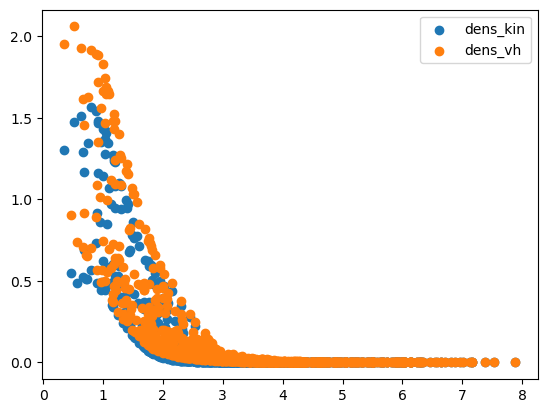

In [23]:
plt.scatter(r, dens_kin, label='dens_kin')
plt.scatter(r, dens_vh, label='dens_vh')
# plt.scatter(r, excd, label='excd')
# plt.scatter(r, rho, label='rho')
# plt.scatter(r, (dens_kin+dens_vh+excd+dens_ein)/rho_p)
# plt.ylim((-10,10))
plt.legend()

In [14]:
kin.shape

(10, 10)

In [15]:
ao.shape

NameError: name 'ao' is not defined